In [3]:
# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [4]:
import twitter
import time
import re

CONSUMER_KEY = "8KzZIa6nmoliHTeaYp8y7QGpD"
CONSUMER_SECRET = "0LO1GYKNIErooRVpYUIpfBcuh0kZKPufQGu4brZqOIHpemVbvE"

ACCESS_TOKEN_KEY = "781082622797709312-27h0Oejfn0apHG7GGMjpBzdNPpjbaKK"
ACCESS_TOKEN_SECRET = "ZIerZq7qN8o5FY0p2mlfNVh1nl8x2B4vqGISL7lkcnIGy"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET) #sleep_on_rate_limit=True)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [5]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    # your code here
    status = api.GetUserTimeline(user_id=user_id, count=200, include_rts=False, exclude_replies=True, trim_user=True)
    tweets = []
    for s in status:
        tweet = {'lang': s.lang, 'favorited': s.favorited, 
             'truncated': s.truncated, 
             'text': re.sub(r"http\S+|@\S+|&\S+", ' ', s.text), 
             'created_at': s.created_at, 
             'retweeted': s.retweeted, 
             'source': s.source, 
             'user': {'id': s.user.id}, 
             'id': s.id}
        if(s.lang == 'en'): tweets.append(tweet)
    return tweets

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [6]:
def get_words(text):
    """returns list of words"""
    # your code here
    return re.findall('([a-z]+)', text.lower()) #re.split('\W+', text.lower())

In [7]:
print get_words("Here are different words!")

['here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [8]:
import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [9]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [10]:
from nltk.stem.lancaster import LancasterStemmer
ls = LancasterStemmer()

In [11]:
def get_tokens(words):
    """returns list of tokens"""
    # your code here
    stopwords = nltk.corpus.stopwords.words('english')
    return [ls.stem(word) for word in words if word not in stopwords]

In [12]:
print get_tokens(["here", "are", "different", "words", "presumably", "she", "presumes"])

['diff', 'word', 'presum', 'presum']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [13]:
def get_tweet_tokens(tweet):
    # your code here
    words = get_words(tweet)
    return get_tokens(words)

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [14]:
from sklearn.feature_extraction import DictVectorizer

In [15]:
from collections import Counter

In [16]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    # your code here
    # save intermediate result
    users = []
    users_tokens = []
    i = 0
    for usr in df_users['uid']:
        try:
            twts = get_user_tweets(usr)
            users.append(usr)
            i += 1
            if i > 800:
                time.sleep(60*15)
                i = 0
        except:
            continue
        tokens = []
        for t in twts:
            tokens += get_tweet_tokens(t['text'])
        users_tokens.append(dict(Counter(tokens)))
    return users, users_tokens
        
    '''try:
           users_tweets.append(get_user_tweets(usr))
           users.append(usr)
        except:
            continue
     for tweets in users_tweets:
        t_tokens = []
        for tweet in tweets:
            t_token.append(get_tweet_tokens(tweet['text']))
    '''
            
    
    #return [12345], [{u'eye': 1, u'floor': 1, u'tweeting': 1, u'n': 1, u'black': 1, u'nose': 1, u'w': 1, u'swollen': 1, u"i'm": 1, u'prob': 1}]


In [17]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cls"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [17]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [28]:
from pytagcloud import create_tag_image, make_tags

In [46]:
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    # your code here
    dicts = v.inverse_transform(vs)
    A = Counter()
    for d in dicts:
        A += Counter(d)
    tokensdict = dict(A)
    tokens = []
    for key in tokensdict.keys():
        tokens.append([key, int(tokensdict[key])])
    tags = make_tags(tokens, maxsize=120)
    create_tag_image(tags[:500], 'cloud.png', size=(600, 600), fontname='Lobster')
    return

In [47]:
draw_tag_cloud(v, vs)

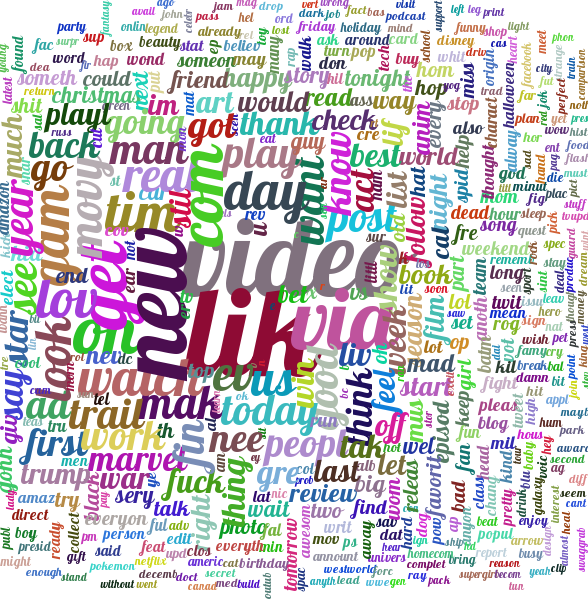

In [59]:
from IPython.display import Image
Image('cloud.png')